### [Tutorial](https://www.analyticsvidhya.com/blog/2020/01/link-prediction-how-to-predict-your-future-connections-on-facebook/) 

In [1]:
import jsonlines
import os
from collections import defaultdict
import sys
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

### Read Data (nodes and edges)

In [2]:
# load nodes details
with open("data/fb-pages-food/fb-pages-food.nodes") as f:
    fb_nodes = f.read().splitlines() 

# load edges (or links)
with open("data/fb-pages-food/fb-pages-food.edges") as f:
    fb_links = f.read().splitlines() 

len(fb_nodes), len(fb_links)

(621, 2102)

In [3]:
# captture nodes in 2 separate lists
node_list_1 = []
node_list_2 = []

for i in tqdm(fb_links):
  node_list_1.append(i.split(',')[0])
  node_list_2.append(i.split(',')[1])

fb_df = pd.DataFrame({'node_1': node_list_1, 'node_2': node_list_2})

100%|██████████| 2102/2102 [00:00<00:00, 575372.12it/s]


In [4]:
fb_df.head()

,node_1,node_2
0,0,276
1,0,58
2,0,132
3,0,603
4,0,398


### Create and visualize the graph

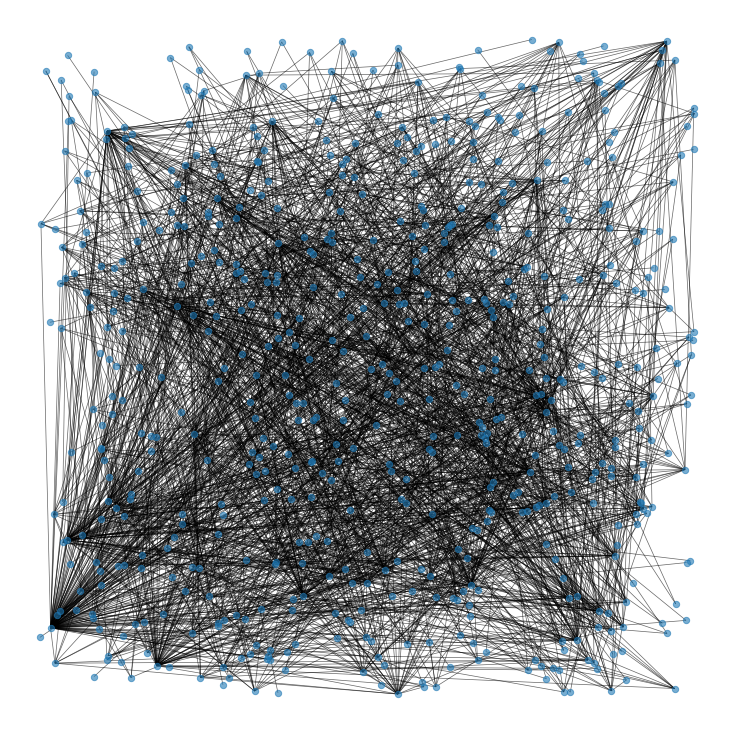

In [5]:
# create graph
G = nx.from_pandas_edgelist(fb_df, "node_1", "node_2", create_using=nx.Graph())

# plot graph
plt.figure(figsize=(10,10))

pos = nx.random_layout(G)
nx.draw(G, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

In [6]:
# combine all nodes in a list
node_list = node_list_1 + node_list_2

# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))

# build adjacency matrix
adj_G = nx.to_numpy_matrix(G, nodelist = node_list)

In [7]:
adj_G.shape, type(adj_G), adj_G

((620, 620),
 numpy.matrix,
 matrix([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]))

### Find position of zeros

In [8]:
# get unconnected node-pairs
all_unconnected_pairs = []

# traverse adjacency matrix
offset = 0
for i in tqdm(range(adj_G.shape[0])):
  for j in range(offset,adj_G.shape[1]):
    if i != j:
      if nx.shortest_path_length(G, str(i), str(j)) <=2:
        if adj_G[i,j] == 0:
          all_unconnected_pairs.append([node_list[i],node_list[j]])

  offset = offset + 1

100%|██████████| 620/620 [00:09<00:00, 63.05it/s] 


In [9]:
### Number of unconnected node pairs
len(all_unconnected_pairs)

19018

### Create Negative samples

In [10]:
node_1_unlinked = [i[0] for i in all_unconnected_pairs]
node_2_unlinked = [i[1] for i in all_unconnected_pairs]

data = pd.DataFrame({'node_1':node_1_unlinked, 
                     'node_2':node_2_unlinked})

# add target variable 'link'
data['link'] = 0

### Create the positive samples (by dropping of some connections so that the graph remains connected)

In [11]:
initial_node_count = len(G.nodes)

fb_df_temp = fb_df.copy()

# empty list to store removable links
omissible_links_index = []

for i in tqdm(fb_df.index.values):
  
  # remove a node pair and build a new graph
  G_temp = nx.from_pandas_edgelist(fb_df_temp.drop(index = i), "node_1", "node_2", create_using=nx.Graph())
  
  # check there is no spliting of graph and number of nodes is same
  if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
    omissible_links_index.append(i)
    fb_df_temp = fb_df_temp.drop(index = i)

100%|██████████| 2102/2102 [00:08<00:00, 242.34it/s]


In [12]:
len(omissible_links_index)

1483

### Combine positive and negative samples

In [13]:
# create dataframe of removable edges
fb_df_ghost = fb_df.loc[omissible_links_index]

# add the target variable 'link'
fb_df_ghost['link'] = 1

data = data.append(fb_df_ghost[['node_1', 'node_2', 'link']], ignore_index=True)

In [14]:
data['link'].value_counts()

0    19018
1     1483
Name: link, dtype: int64

### Feature extraction

In [15]:
## Build a new graph by droping removable links (node2vec algo)
# drop removable edges
fb_df_partial = fb_df.drop(index=fb_df_ghost.index.values)

# build graph
G_data = nx.from_pandas_edgelist(fb_df_partial, "node_1", "node_2", create_using=nx.Graph())

In [16]:
# !pip install node2vec


### Train Node2Vec on the graph

In [17]:
from node2vec import Node2Vec

# Generate walks
node2vec = Node2Vec(G_data, dimensions=100, walk_length=16, num_walks=50)

# train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1)

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:19<00:00,  2.57it/s]


### Get the features for each node pairs (concatenated)

In [18]:
x = [(n2w_model[str(i)]+n2w_model[str(j)]) for i,j in zip(data['node_1'], data['node_2'])]

/home/kkpal/.conda/envs/newtransformers/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [20]:
x[1].shape

(100,)

### Split data into train-test

In [21]:
xtrain, xtest, ytrain, ytest = train_test_split(np.array(x), data['link'], 
                                                test_size = 0.3, 
                                                random_state = 35)

### Logistic Regression

In [22]:
lr = LogisticRegression(class_weight="balanced")
lr.fit(xtrain, ytrain)

/home/kkpal/.conda/envs/newtransformers/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(class_weight='balanced')

In [23]:
predictions = lr.predict_proba(xtest)

In [24]:
roc_auc_score(ytest, predictions[:,1])

0.7844689573980343

### LightGBM

In [26]:
!pip install lightgbm

     |████████████████████████████████| 1.7 MB 3.1 MB/s 


In [27]:
import lightgbm as lgbm

train_data = lgbm.Dataset(xtrain, ytrain)
test_data = lgbm.Dataset(xtest, ytest)

# define parameters
parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'num_threads' : 2,
    'seed' : 76
}

# train lightGBM model
model = lgbm.train(parameters,
                   train_data,
                   valid_sets=test_data,
                   num_boost_round=1000,
                   early_stopping_rounds=20)

[LightGBM] [Info] Number of positive: 1062, number of negative: 13288
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 14350, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074007 -> initscore=-2.526707
[LightGBM] [Info] Start training from score -2.526707
[1]	valid_0's auc: 0.709837
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.754863
[3]	valid_0's auc: 0.783182
[4]	valid_0's auc: 0.79184
[5]	valid_0's auc: 0.803361
[6]	valid_0's auc: 0.813865
[7]	valid_0's auc: 0.821649
[8]	valid_0's auc: 0.828253
[9]	valid_0's auc: 0.833107
[10]	valid_0's auc: 0.838117
[11]	valid_0's auc: 0.842525
[12]	valid_0's auc: 0.84566
[13]	valid_0's auc: 0.852325
[14]	valid_